## Count number of valid genes after applying cancer type filters

In [the preprocessing code for our classifiers](https://github.com/greenelab/mpmp/blob/5d5fa0823b00fc3080d3a9db69d8d6704f554549/mpmp/utilities/tcga_utilities.py#L84), we originally filtered out cancer types that don't contain at least 5% of samples mutated and at least 10 total samples mutated, for a given target gene.

Here, we want to try a different approach (TODO: describe)

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import mpmp.config as cfg
from mpmp.data_models.tcga_data_model import TCGADataModel
import mpmp.utilities.data_utilities as du

%load_ext autoreload
%autoreload 2

In [2]:
# data types to use
overlap_data_types = [
    'expression',
    'me_27k',
    'me_450k',
    'rppa',
    'mirna',
    'mut_sigs',
]

# load sample info and mutation data, this takes some time
tcga_data = TCGADataModel(seed=cfg.default_seed,
                          verbose=False,
                          overlap_data_types=overlap_data_types)
pancancer_data = du.load_pancancer_data()

In [3]:
# load merged gene set info
genes_df = du.load_merged()
genes_df.head()

,gene,classification
0,ABI1,TSG
1,ABL1,Oncogene
2,ABL2,Oncogene
3,ACKR3,Oncogene
4,ACVR1,Oncogene


In [4]:
def gene_mutation_count(gene,
                        data_model,
                        classification='neither',
                        filter_cancer_types=False):
    """Count mutations for a given gene."""
    try:
        tcga_data.process_data_for_gene(
            gene,
            classification,
            './gene_mutation_counts',
            filter_cancer_types=filter_cancer_types
        )
        count_df = pd.read_csv(
            './gene_mutation_counts/{}_filtered.tsv'.format(gene),
            sep='\t'
        )
        return count_df.loc[0].values.tolist()
    except KeyError:
        return [0, 0, True]
        
gene_mutation_count('TP53', tcga_data, 'TSG')

[1853, 0.367512891709639, False]

In [5]:
gene_counts_df = []

for g_id, g_series in genes_df.iterrows():
    gene_info = gene_mutation_count(
        g_series.gene,
        tcga_data,
        g_series.classification
    )
    gene_counts_df.append([g_series.gene] + gene_info)
    
gene_counts_df = pd.DataFrame(
    gene_counts_df,
    columns=['gene', 'count', 'prop', 'filter_gene']
)
print(gene_counts_df.shape)
gene_counts_df.head(20)

(511, 4)


,gene,count,prop,filter_gene
0,ABI1,24,0.004760,True
1,ABL1,79,0.015668,True
2,ABL2,170,0.033717,False
3,ACKR3,31,0.006148,True
4,ACVR1,49,0.009718,True
5,ACVR1B,54,0.010710,True
6,ACVR2A,100,0.019833,False
7,AFDN,0,0.000000,True
8,AFF3,130,0.025783,False
9,AFF4,73,0.014478,True


Number of genes passing filters: 182 / 511
Number of genes passing filters: 182 / 511


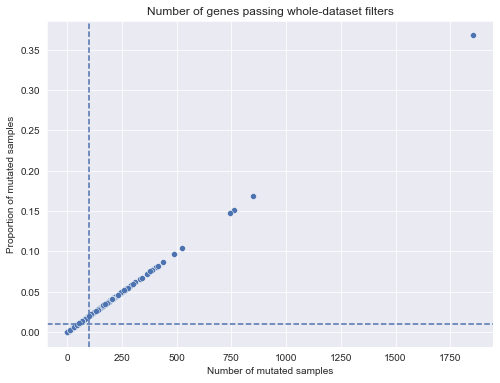

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set({'figure.figsize': (8, 6)})

sns.scatterplot(data=gene_counts_df, x='count', y='prop')
plt.xlabel('Number of mutated samples')
plt.ylabel('Proportion of mutated samples')
plt.title('Number of genes passing whole-dataset filters')

count_thresh = 100
prop_thresh = 0.01
plt.gca().axhline(y=prop_thresh, linestyle='--')
plt.gca().axvline(x=count_thresh, linestyle='--')

thresh_genes = gene_counts_df.shape[0] - gene_counts_df.filter_gene.sum()
print('Number of genes passing filters: {} / {}'.format(
      thresh_genes, gene_counts_df.shape[0]))